In [1]:
# 05_sp500_cs_tree_robustness.ipynb
# Robustness of cross-sectional SP500 tree vs momentum across multiple test windows

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import optuna
from sklearn.ensemble import HistGradientBoostingRegressor

plt.style.use("seaborn-v0_8-darkgrid")

def sharpe_ratio_np(returns, freq: int = 252) -> float:
    """Simple annualized Sharpe on a 1D array of daily returns."""
    r = np.asarray(returns, dtype=float)
    if r.size == 0 or np.isclose(r.std(), 0.0):
        return 0.0
    return np.sqrt(freq) * r.mean() / r.std()


C:\Users\gehra\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)

%load_ext autoreload
%autoreload 2

from src.data_loading_cross import load_sp500_adj_close
from src.signals_cross import (
    make_cross_sectional_signals,
    build_cross_sectional_matrix,
    CROSS_FEATURES,
)

from src.backtest import (
    equity_curve_from_returns,
    cagr,
    annualized_vol,
    sharpe_ratio,
    max_drawdown,
)


PROJECT_ROOT: c:\Users\gehra\Documents\GitHub\Quant_coding


In [3]:
# --- Global transaction cost setting ---
# round-trip cost as a fraction of notional per 21-day "trade"
# 0.0005 = 5 bps, 0.001 = 10 bps, etc.
COST_BPS = 0.001  # tweak this to whatever you want to assume


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6530 entries, 2000-01-03 to 2025-12-17
Columns: 453 entries, NVDA to NWS
dtypes: float64(453)
memory usage: 22.6 MB
Price panel shape: (6530, 453)
Date range: 2000-01-03 00:00:00 -> 2025-12-17 00:00:00
Number of tickers: 453


c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:47: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_1 = prices.pct_change(1)
c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:48: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_5 = prices.pct_change(5)
c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:49: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill N

Signals shape: (2505045, 12)
Columns: ['ret_1', 'ret_5', 'ret_10', 'ret_21', 'vol_10', 'vol_20', 'vol_60', 'ma20_rel', 'ma50_rel', 'ma200_rel', 'target_fwd_21', 'dow']
Signals date range: 2000-10-16 00:00:00 -> 2025-11-17 00:00:00
Unique tickers in signals: 451
X shape: (2505045, 11)
y shape: (2505045,)
Feature names: ['ret_1', 'ret_5', 'ret_10', 'ret_21', 'vol_10', 'vol_20', 'vol_60', 'ma20_rel', 'ma50_rel', 'ma200_rel', 'dow']
Min/max date: 2000-10-16 00:00:00 -> 2025-11-17 00:00:00
Num unique tickers: 451


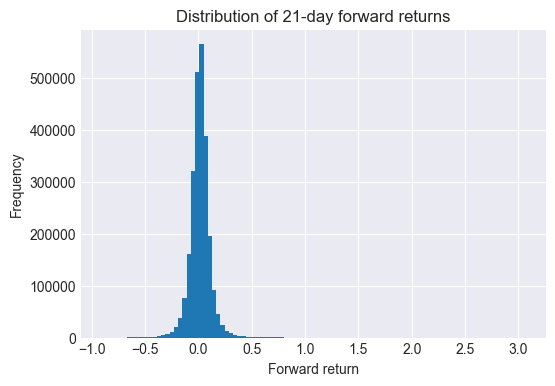

In [4]:
# Load SP500 panel as long as we can reasonably go
# (set force_download=True the first time if needed)
prices = load_sp500_adj_close(start="2000-01-01")

prices.info()
print("Price panel shape:", prices.shape)
print("Date range:", prices.index.min(), "->", prices.index.max())
print("Number of tickers:", len(prices.columns))

lookahead = 21  # ~1 month forward return

signals_df = make_cross_sectional_signals(prices, lookahead=lookahead)

print("Signals shape:", signals_df.shape)
print("Columns:", signals_df.columns.tolist())

dates_all = signals_df.index.get_level_values("date")
tickers_all = signals_df.index.get_level_values("ticker")

print("Signals date range:", dates_all.min(), "->", dates_all.max())
print("Unique tickers in signals:", len(np.unique(tickers_all)))

# Build big (X, y, dates, tickers) matrix
X, y, dates, tickers = build_cross_sectional_matrix(signals_df)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Feature names:", CROSS_FEATURES)
print("Min/max date:", dates.min(), "->", dates.max())
print("Num unique tickers:", np.unique(tickers).size)

# Quick sanity check on forward-return distribution
plt.figure(figsize=(6, 4))
plt.hist(y, bins=100)
plt.title(f"Distribution of {lookahead}-day forward returns")
plt.xlabel("Forward return")
plt.ylabel("Frequency")
plt.show()


In [5]:
def daily_momentum_cs(
    group: pd.DataFrame,
    q: float = 0.1,
    horizon: int = 21,
    cost_bps: float = 0.0,
) -> pd.Series:
    """
    Cross-sectional momentum for a single date.

    group: rows for one date, many tickers.
    q: top/bottom quantile, e.g. 0.1 for deciles.
    horizon: forward horizon used for the target (e.g. 21 days).
    cost_bps: round-trip cost per 21-day position (same meaning as above).
    """
    n = len(group)
    if n < 10:
        return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

    # equal-weight all stocks -> "index" (21-day return, frictionless)
    eqw_ret_21 = group["target_fwd_21"].mean()

    # sort by past 21d return (classical cross-sectional momentum)
    g_sorted = group.sort_values("ret_21")
    k = max(1, int(n * q))

    bottom = g_sorted.iloc[:k]
    top    = g_sorted.iloc[-k:]

    long_ret_21  = top["target_fwd_21"].mean()
    short_ret_21 = bottom["target_fwd_21"].mean()
    long_short_21 = long_ret_21 - short_ret_21

    # Apply transaction costs on 21-day horizon
    if cost_bps > 0.0:
        long_ret_21   = (1.0 + long_ret_21) * (1.0 - cost_bps) - 1.0
        long_short_21 = (1.0 + long_short_21) * (1.0 - 2.0 * cost_bps) - 1.0

    # convert to daily
    def to_daily(R):
        return (1.0 + R) ** (1.0 / horizon) - 1.0

    eqw_ret_daily   = to_daily(eqw_ret_21)
    long_ret_daily  = to_daily(long_ret_21)
    long_short_daily = to_daily(long_short_21)

    return pd.Series(
        {
            "eqw": eqw_ret_daily,
            "long": long_ret_daily,
            "long_short": long_short_daily,
        }
    )


def compute_cs_daily_returns(
    df: pd.DataFrame,
    q: float = 0.1,
    horizon: int = 21,
    cost_bps: float = 0.0,
):
    """
    df: index (date, symbol), columns: y_true, y_pred (21d fwd returns + predictions)
    Returns three Series of *daily-equivalent* returns:
        eqw, long-only (top q), long-short (top q minus bottom q)

    cost_bps:
        round-trip transaction cost per 21-day holding period as fraction
        e.g. 0.0005 = 5 bps, 0.001 = 10 bps.
        Applied once for a long-only position and twice for a long-short position.
    """

    def _per_date(group: pd.DataFrame) -> pd.Series:
        n = len(group)
        if n < 10:
            return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

        # Equal-weight all stocks -> benchmark (frictionless)
        eqw_ret_21 = group["y_true"].mean()

        # Sort by predicted forward return
        g_sorted = group.sort_values("y_pred")
        k = max(1, int(n * q))

        bottom = g_sorted.iloc[:k]     # worst predicted
        top    = g_sorted.iloc[-k:]    # best predicted

        long_ret_21  = top["y_true"].mean()
        short_ret_21 = bottom["y_true"].mean()

        # 21d long-short return before costs
        long_short_21 = long_ret_21 - short_ret_21

        # --- Apply transaction costs on the 21-day horizon ---
        # long-only: 1 round-trip -> cost_bps
        # long-short: 2 round-trips (long + short) -> 2 * cost_bps
        if cost_bps > 0.0:
            long_ret_21      = (1.0 + long_ret_21) * (1.0 - cost_bps) - 1.0
            long_short_21    = (1.0 + long_short_21) * (1.0 - 2.0 * cost_bps) - 1.0

        # convert 21-day returns to daily-equivalent
        def to_daily(R):
            return (1.0 + R) ** (1.0 / horizon) - 1.0

        eqw_daily        = to_daily(eqw_ret_21)
        long_daily       = to_daily(long_ret_21)
        long_short_daily = to_daily(long_short_21)

        return pd.Series(
            {"eqw": eqw_daily, "long": long_daily, "long_short": long_short_daily}
        )

    daily = df.groupby("date").apply(_per_date)

    eqw = daily["eqw"].astype(float)
    long = daily["long"].astype(float)
    long_short = daily["long_short"].astype(float)

    return eqw, long, long_short


In [6]:
def compute_cs_daily_returns_gated(
    df: pd.DataFrame,
    q: float = 0.1,
    horizon: int = 21,
    cost_bps: float = 0.0,
):
    """
    Like compute_cs_daily_returns, but:
    - uses model predictions to decide whether to trade at all,
    - only applies costs on days where we actually trade.

    df: index (date, symbol), columns: y_true, y_pred
    """

    def _per_date(group: pd.DataFrame) -> pd.Series:
        n = len(group)
        if n < 10:
            return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

        # Benchmark: equal-weight all stocks (no costs)
        eqw_ret_21 = group["y_true"].mean()

        # Rank by predicted forward return
        g_sorted = group.sort_values("y_pred")
        k = max(1, int(n * q))

        bottom = g_sorted.iloc[:k]
        top    = g_sorted.iloc[-k:]

        # --- True 21d returns (what actually happens) ---
        long_true_21  = top["y_true"].mean()
        short_true_21 = bottom["y_true"].mean()
        long_short_true_21 = long_true_21 - short_true_21

        # --- Predicted 21d returns (model view) ---
        long_pred_21  = top["y_pred"].mean()
        short_pred_21 = bottom["y_pred"].mean()
        long_short_pred_21 = long_pred_21 - short_pred_21

        # ---- Decision: do we trade? ----
        # Long-only: require predicted edge > cost
        trade_long = long_pred_21 > cost_bps

        # Long-short: require predicted spread > 2 * cost
        trade_ls   = long_short_pred_21 > 2.0 * cost_bps

        # Start from "no trade"
        long_ret_21      = 0.0
        long_short_21    = 0.0

        if trade_long:
            long_ret_21 = long_true_21

        if trade_ls:
            long_short_21 = long_short_true_21

        # ---- Apply costs only if we actually trade ----
        if cost_bps > 0.0 and trade_long:
            long_ret_21 = (1.0 + long_ret_21) * (1.0 - cost_bps) - 1.0

        if cost_bps > 0.0 and trade_ls:
            long_short_21 = (1.0 + long_short_21) * (1.0 - 2.0 * cost_bps) - 1.0

        # Convert 21-day returns to daily-equivalent
        def to_daily(R):
            return (1.0 + R) ** (1.0 / horizon) - 1.0

        eqw_daily        = to_daily(eqw_ret_21)
        long_daily       = to_daily(long_ret_21)
        long_short_daily = to_daily(long_short_21)

        return pd.Series(
            {"eqw": eqw_daily, "long": long_daily, "long_short": long_short_daily}
        )

    daily = df.groupby("date").apply(_per_date)

    eqw = daily["eqw"].astype(float)
    long = daily["long"].astype(float)
    long_short = daily["long_short"].astype(float)

    return eqw, long, long_short


In [7]:
def run_cs_window(
    test_start: str,
    test_end: str,
    n_trials: int = 10,
    q_mom: float = 0.1,
    random_state: int = 42,
):
    """
    Run the full pipeline for a single test window:
    - Train/val on data *before* test_start
    - Tune tree + q on validation long-short Sharpe (net of costs)
    - Evaluate momentum and tree on [test_start, test_end] (net of costs)
    """
    test_start = pd.Timestamp(test_start)
    test_end   = pd.Timestamp(test_end)

    # Masks for this window
    test_mask = (dates >= test_start) & (dates <= test_end)
    hist_mask = dates < test_start

    if test_mask.sum() == 0 or hist_mask.sum() < 1000:
        print(f"Skipping window {test_start.date()}–{test_end.date()} (not enough data).")
        return None

    hist_dates = np.array(sorted(dates[hist_mask].unique()))
    # 70/30 split of *history* into train/val
    train_end_local = hist_dates[int(len(hist_dates) * 0.7)]

    train_mask = (dates <= train_end_local)
    val_mask   = (dates > train_end_local) & (dates < test_start)

    X_train, y_train = X[train_mask], y[train_mask]
    X_val,   y_val   = X[val_mask],   y[val_mask]
    X_test,  y_test  = X[test_mask],  y[test_mask]

    dates_val_local    = dates[val_mask]
    dates_test_local   = dates[test_mask]
    tickers_val_local  = tickers[val_mask]
    tickers_test_local = tickers[test_mask]

    print(
        f"Window {test_start.date()}–{test_end.date()} | "
        f"train={len(y_train)}, val={len(y_val)}, test={len(y_test)}"
    )

    # -------------------------
    # Optuna objective for this window (tree + q, net-of-cost Sharpe)
    # -------------------------
    def objective_tree_cs(trial):
        max_depth = trial.suggest_int("max_depth", 2, 8)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
        max_iter = trial.suggest_int("max_iter", 100, 500)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 20, 200)

        q = trial.suggest_float("q", 0.05, 0.3)  # top/bottom 5–30%

        model = HistGradientBoostingRegressor(
            max_depth=max_depth,
            learning_rate=learning_rate,
            max_iter=max_iter,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
        )
        model.fit(X_train, y_train)

        y_pred_val = model.predict(X_val)

        df_val = pd.DataFrame(
            {
                "date":   dates_val_local,
                "symbol": tickers_val_local,
                "y_true": y_val,
                "y_pred": y_pred_val,
            }
        ).set_index(["date", "symbol"]).sort_index()

        # Build portfolios on validation (net of costs)


        _, long_val, long_short_val = compute_cs_daily_returns_gated(
            df_val,
            q=q,
            horizon=lookahead,
            cost_bps=COST_BPS,
        )


        ret_series = long_short_val.replace([np.inf, -np.inf], np.nan).dropna()

        if len(ret_series) < 20:
            return 0.0

        return -sharpe_ratio_np(ret_series.values)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective_tree_cs, n_trials=n_trials)

    print("  Best params:", study.best_params)
    print("  Best val -Sharpe:", study.best_value)

    best_params = study.best_params.copy()
    q_best = best_params.pop("q")

    tree_best = HistGradientBoostingRegressor(
        **best_params,
        random_state=random_state,
    )

    # Train on all history (train+val) prior to test_start
    hist_mask_full = dates < test_start
    X_hist, y_hist = X[hist_mask_full], y[hist_mask_full]
    tree_best.fit(X_hist, y_hist)

    # -------------------------
    # Evaluate on TEST window
    # -------------------------

    # 1) Momentum baseline on this test window (net of costs)
    idx_dates = signals_df.index.get_level_values("date")
    signals_test = signals_df.loc[
        (idx_dates >= test_start) & (idx_dates <= test_end)
    ].copy()

    daily_mom = signals_test.groupby("date").apply(
        daily_momentum_cs,
        q=q_mom,
        horizon=lookahead,
        cost_bps=COST_BPS,
    )

    eqw_returns   = daily_mom["eqw"].astype(float)
    momL_returns  = daily_mom["long"].astype(float)
    momLS_returns = daily_mom["long_short"].astype(float)


    # 2) Tree strategy on this test window (net of costs)
    y_pred_test = tree_best.predict(X_test)

    df_test = pd.DataFrame(
        {
            "date":   dates_test_local,
            "symbol": tickers_test_local,
            "y_true": y_test,
            "y_pred": y_pred_test,
        }
    ).set_index(["date", "symbol"]).sort_index()



    _, treeL_returns, treeLS_returns = compute_cs_daily_returns_gated(
    df_test,
    q=q_best,
    horizon=lookahead,
    cost_bps=COST_BPS,
    )


    # 3) Equity curves + metrics
    eqw_eq    = equity_curve_from_returns(eqw_returns)
    momL_eq   = equity_curve_from_returns(momL_returns)
    momLS_eq  = equity_curve_from_returns(momLS_returns)
    treeL_eq  = equity_curve_from_returns(treeL_returns)
    treeLS_eq = equity_curve_from_returns(treeLS_returns)

    metrics = {
        "test_start": test_start.date(),
        "test_end":   test_end.date(),

        "momL_cagr":    cagr(momL_eq),
        "momL_sharpe":  sharpe_ratio(momL_returns),
        "momL_max_dd":  max_drawdown(momL_eq),

        "treeL_cagr":   cagr(treeL_eq),
        "treeL_sharpe": sharpe_ratio(treeL_returns),
        "treeL_max_dd": max_drawdown(treeL_eq),

        "momLS_cagr":   cagr(momLS_eq),
        "momLS_sharpe": sharpe_ratio(momLS_returns),
        "momLS_max_dd": max_drawdown(momLS_eq),

        "treeLS_cagr":   cagr(treeLS_eq),
        "treeLS_sharpe": sharpe_ratio(treeLS_returns),
        "treeLS_max_dd": max_drawdown(treeLS_eq),
    }

    # quick plots for this window
    plt.figure(figsize=(9, 4))
    momL_eq.plot(label="Momentum long-only")
    treeL_eq.plot(label="Tree long-only (Optuna)")
    plt.legend()
    plt.title(f"Long-only (net costs): {test_start.date()}–{test_end.date()}")
    plt.show()

    plt.figure(figsize=(9, 4))
    momLS_eq.plot(label="Momentum long-short")
    treeLS_eq.plot(label="Tree long-short (Optuna)")
    plt.legend()
    plt.title(f"Long-short (net costs): {test_start.date()}–{test_end.date()}")
    plt.show()

    return metrics


In [8]:
# Choose several non-overlapping test windows.
# Training/validation for each window uses *only data before* test_start.
test_windows = [
    ("2005-01-01", "2009-12-31"),
    ("2010-01-01", "2014-12-31"),
    ("2015-01-01", "2019-12-31"),
    ("2020-01-01", "2024-12-31"),
]
test_windows


[('2005-01-01', '2009-12-31'),
 ('2010-01-01', '2014-12-31'),
 ('2015-01-01', '2019-12-31'),
 ('2020-01-01', '2024-12-31')]

[I 2025-12-21 08:57:24,954] A new study created in memory with name: no-name-91c69fcb-1ca3-4dac-8916-b24caa86bcad


Window 2005-01-01–2009-12-31 | train=242459, val=107861, test=459337


[I 2025-12-21 08:57:33,900] Trial 0 finished with value: -0.7445455052642748 and parameters: {'max_depth': 3, 'learning_rate': 0.026851877634879503, 'max_iter': 150, 'min_samples_leaf': 103, 'q': 0.2164007534408533}. Best is trial 0 with value: -0.7445455052642748.
[I 2025-12-21 08:57:50,968] Trial 1 finished with value: -0.43780158631664823 and parameters: {'max_depth': 5, 'learning_rate': 0.13969909521627802, 'max_iter': 407, 'min_samples_leaf': 27, 'q': 0.21343542742842803}. Best is trial 0 with value: -0.7445455052642748.
[I 2025-12-21 08:58:04,625] Trial 2 finished with value: -1.5613710600478965 and parameters: {'max_depth': 3, 'learning_rate': 0.0289264751339984, 'max_iter': 381, 'min_samples_leaf': 150, 'q': 0.12312459382189637}. Best is trial 2 with value: -1.5613710600478965.
[I 2025-12-21 08:58:12,055] Trial 3 finished with value: 0.7363649212715433 and parameters: {'max_depth': 3, 'learning_rate': 0.03380840710563871, 'max_iter': 312, 'min_samples_leaf': 48, 'q': 0.28101403

  Best params: {'max_depth': 5, 'learning_rate': 0.028988020359269628, 'max_iter': 237, 'min_samples_leaf': 105, 'q': 0.13896507841873057}
  Best val -Sharpe: -2.1267536519840187


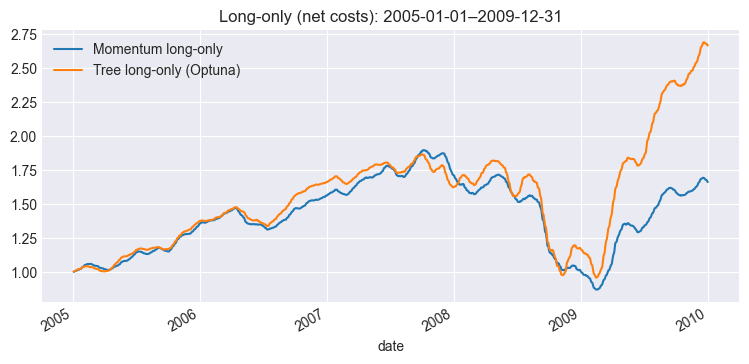

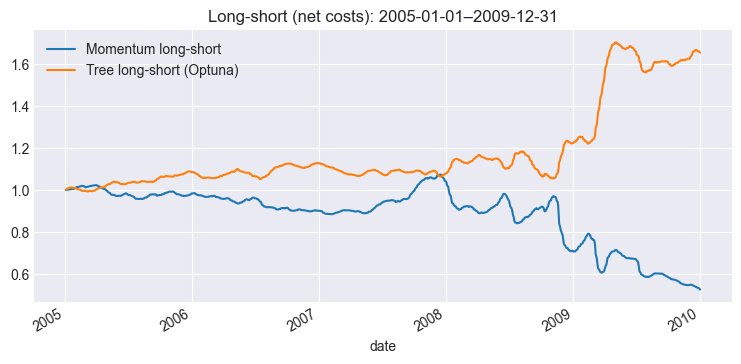

[I 2025-12-21 08:59:12,105] A new study created in memory with name: no-name-50081080-50ab-4d7f-91a1-723f43dd6db8


Window 2010-01-01–2014-12-31 | train=549813, val=259844, test=501850


[I 2025-12-21 08:59:27,817] Trial 0 finished with value: -3.499174204817685 and parameters: {'max_depth': 8, 'learning_rate': 0.016417531947785672, 'max_iter': 226, 'min_samples_leaf': 171, 'q': 0.19355757391919676}. Best is trial 0 with value: -3.499174204817685.
[I 2025-12-21 08:59:39,225] Trial 1 finished with value: -3.880236794204434 and parameters: {'max_depth': 3, 'learning_rate': 0.15200482746031205, 'max_iter': 333, 'min_samples_leaf': 110, 'q': 0.20305910562924623}. Best is trial 1 with value: -3.880236794204434.
[I 2025-12-21 08:59:56,286] Trial 2 finished with value: -3.504827187802751 and parameters: {'max_depth': 4, 'learning_rate': 0.015026223974569698, 'max_iter': 327, 'min_samples_leaf': 59, 'q': 0.2658061216796395}. Best is trial 1 with value: -3.880236794204434.
[I 2025-12-21 09:00:14,761] Trial 3 finished with value: -3.3960528109489894 and parameters: {'max_depth': 3, 'learning_rate': 0.011041433296954797, 'max_iter': 425, 'min_samples_leaf': 156, 'q': 0.1415307798

  Best params: {'max_depth': 8, 'learning_rate': 0.12228641751623405, 'max_iter': 259, 'min_samples_leaf': 138, 'q': 0.14737757968205795}
  Best val -Sharpe: -4.166027448849652


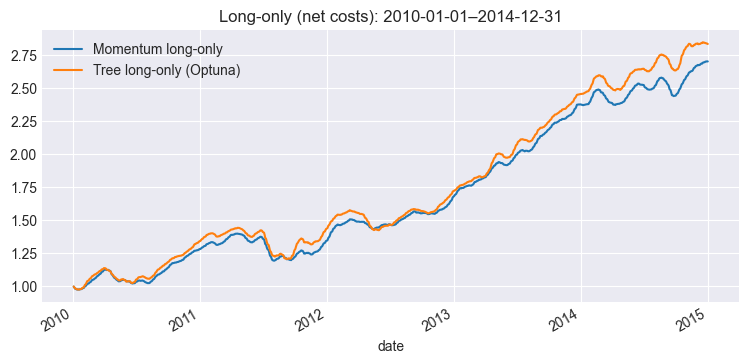

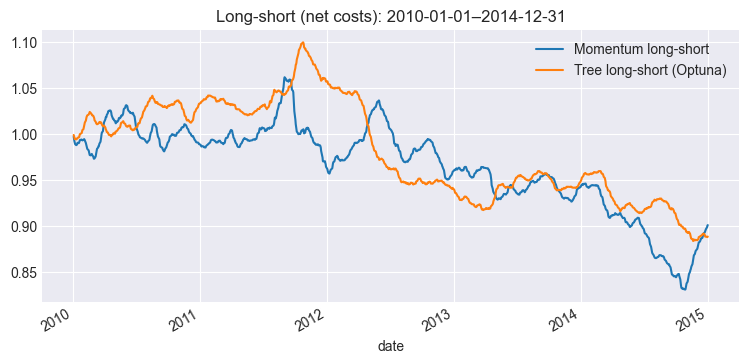

[I 2025-12-21 09:02:37,275] A new study created in memory with name: no-name-066e53b0-97d6-4adc-a4b8-42870715484a


Window 2015-01-01–2019-12-31 | train=880883, val=430624, test=536253


[I 2025-12-21 09:03:12,810] Trial 0 finished with value: -0.14637127421702548 and parameters: {'max_depth': 3, 'learning_rate': 0.04452550189817252, 'max_iter': 469, 'min_samples_leaf': 161, 'q': 0.11810146324170402}. Best is trial 0 with value: -0.14637127421702548.
[I 2025-12-21 09:03:33,032] Trial 1 finished with value: 0.9805776981206755 and parameters: {'max_depth': 6, 'learning_rate': 0.0974881260614477, 'max_iter': 180, 'min_samples_leaf': 121, 'q': 0.15308504942098072}. Best is trial 0 with value: -0.14637127421702548.
[I 2025-12-21 09:03:46,214] Trial 2 finished with value: -0.036219803899861604 and parameters: {'max_depth': 7, 'learning_rate': 0.0796873513329207, 'max_iter': 123, 'min_samples_leaf': 105, 'q': 0.10201427100949974}. Best is trial 0 with value: -0.14637127421702548.
[I 2025-12-21 09:04:11,160] Trial 3 finished with value: 0.8759472786017032 and parameters: {'max_depth': 7, 'learning_rate': 0.16329353038311967, 'max_iter': 309, 'min_samples_leaf': 70, 'q': 0.0864

  Best params: {'max_depth': 6, 'learning_rate': 0.014414931877809888, 'max_iter': 127, 'min_samples_leaf': 161, 'q': 0.07171297774790193}
  Best val -Sharpe: -0.7969118505470293


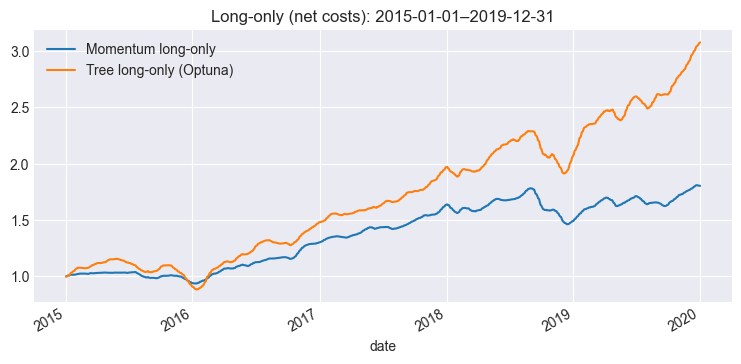

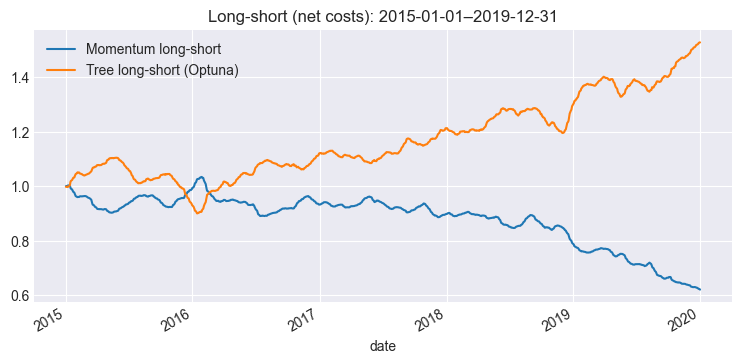

[I 2025-12-21 09:06:23,690] A new study created in memory with name: no-name-3a4b32d9-83b2-4f7f-96c4-638642616dc3


Window 2020-01-01–2024-12-31 | train=1232188, val=615572, test=558111


[I 2025-12-21 09:06:55,984] Trial 0 finished with value: -3.143324408196504 and parameters: {'max_depth': 2, 'learning_rate': 0.026940387143675006, 'max_iter': 401, 'min_samples_leaf': 180, 'q': 0.07957897686299768}. Best is trial 0 with value: -3.143324408196504.
[I 2025-12-21 09:07:58,011] Trial 1 finished with value: -0.8010866773091269 and parameters: {'max_depth': 5, 'learning_rate': 0.1379471935514853, 'max_iter': 464, 'min_samples_leaf': 68, 'q': 0.2284315059218599}. Best is trial 0 with value: -3.143324408196504.
[I 2025-12-21 09:08:13,113] Trial 2 finished with value: -2.103701420959109 and parameters: {'max_depth': 2, 'learning_rate': 0.036007675016857886, 'max_iter': 157, 'min_samples_leaf': 34, 'q': 0.221688879787921}. Best is trial 0 with value: -3.143324408196504.
[I 2025-12-21 09:08:58,343] Trial 3 finished with value: -2.4060102325328874 and parameters: {'max_depth': 4, 'learning_rate': 0.011419438463043203, 'max_iter': 393, 'min_samples_leaf': 56, 'q': 0.24163774563639

  Best params: {'max_depth': 2, 'learning_rate': 0.026940387143675006, 'max_iter': 401, 'min_samples_leaf': 180, 'q': 0.07957897686299768}
  Best val -Sharpe: -3.143324408196504


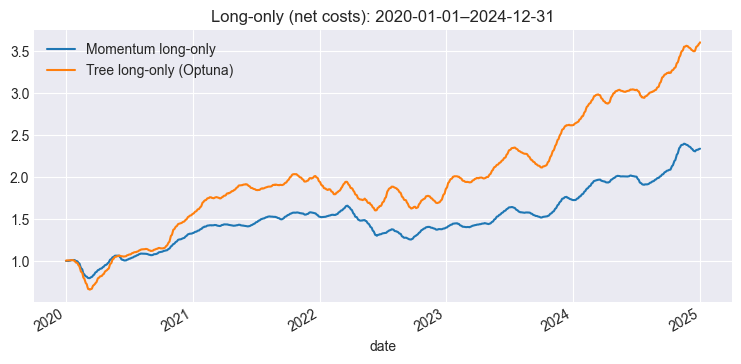

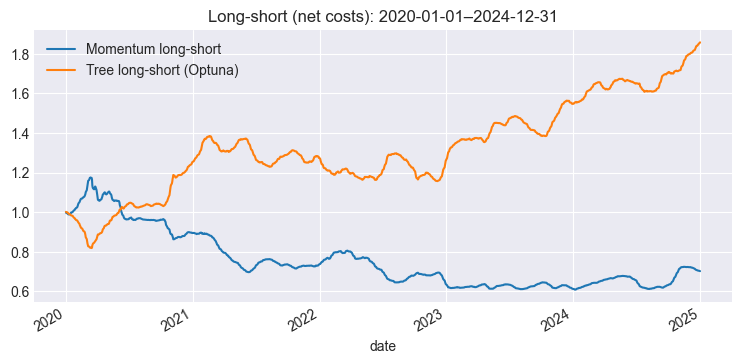

,test_start,test_end,momL_cagr,momL_sharpe,momL_max_dd,treeL_cagr,treeL_sharpe,treeL_max_dd,momLS_cagr,momLS_sharpe,momLS_max_dd,treeLS_cagr,treeLS_sharpe,treeLS_max_dd
0,2005-01-01,2009-12-31,0.106992,1.861044,-0.541993,0.216858,2.896042,-0.487213,-0.121386,-1.875314,-0.511963,0.105880,2.780536,-0.109613
1,2010-01-01,2014-12-31,0.220422,6.471051,-0.146564,0.232009,6.114030,-0.163541,-0.020076,-0.933459,-0.217081,-0.023157,-1.503259,-0.196095
2,2015-01-01,2019-12-31,0.125113,4.379338,-0.179420,0.252277,6.160490,-0.236066,-0.091091,-3.260790,-0.399704,0.089019,2.965978,-0.184780
3,2020-01-01,2024-12-31,0.185737,3.690401,-0.243806,0.292558,4.177259,-0.349073,-0.068187,-1.396745,-0.482553,0.131955,2.940035,-0.182922


In [9]:
results = []

for start, end in test_windows:
    print("=" * 80)
    m = run_cs_window(start, end, n_trials=10, q_mom=0.1)
    if m is not None:
        results.append(m)

results_df = pd.DataFrame(results)
results_df


In [10]:
summary_cols = [
    "test_start", "test_end",
    "momL_sharpe", "treeL_sharpe",
    "momLS_sharpe", "treeLS_sharpe",
]

summary = results_df[summary_cols].copy()
summary


,test_start,test_end,momL_sharpe,treeL_sharpe,momLS_sharpe,treeLS_sharpe
0,2005-01-01,2009-12-31,1.861044,2.896042,-1.875314,2.780536
1,2010-01-01,2014-12-31,6.471051,6.114030,-0.933459,-1.503259
2,2015-01-01,2019-12-31,4.379338,6.160490,-3.260790,2.965978
3,2020-01-01,2024-12-31,3.690401,4.177259,-1.396745,2.940035


In [11]:
summary["treeL_minus_momL"]   = summary["treeL_sharpe"]  - summary["momL_sharpe"]
summary["treeLS_minus_momLS"] = summary["treeLS_sharpe"] - summary["momLS_sharpe"]

summary


,test_start,test_end,momL_sharpe,treeL_sharpe,momLS_sharpe,treeLS_sharpe,treeL_minus_momL,treeLS_minus_momLS
0,2005-01-01,2009-12-31,1.861044,2.896042,-1.875314,2.780536,1.034997,4.655850
1,2010-01-01,2014-12-31,6.471051,6.114030,-0.933459,-1.503259,-0.357020,-0.569800
2,2015-01-01,2019-12-31,4.379338,6.160490,-3.260790,2.965978,1.781151,6.226768
3,2020-01-01,2024-12-31,3.690401,4.177259,-1.396745,2.940035,0.486857,4.336779


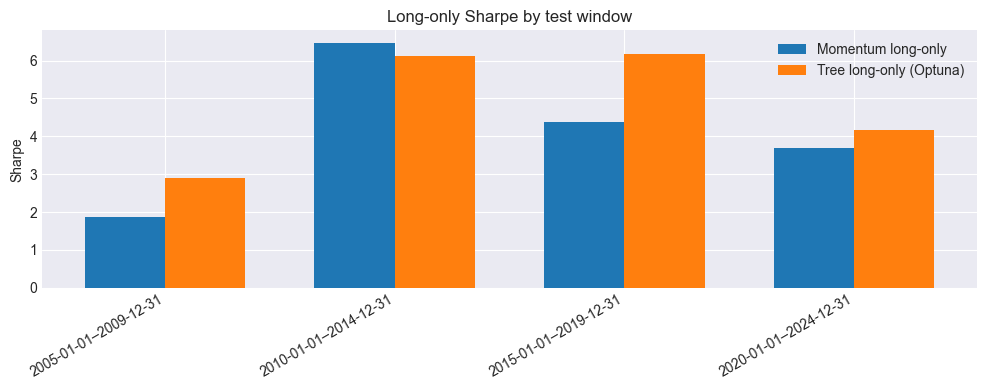

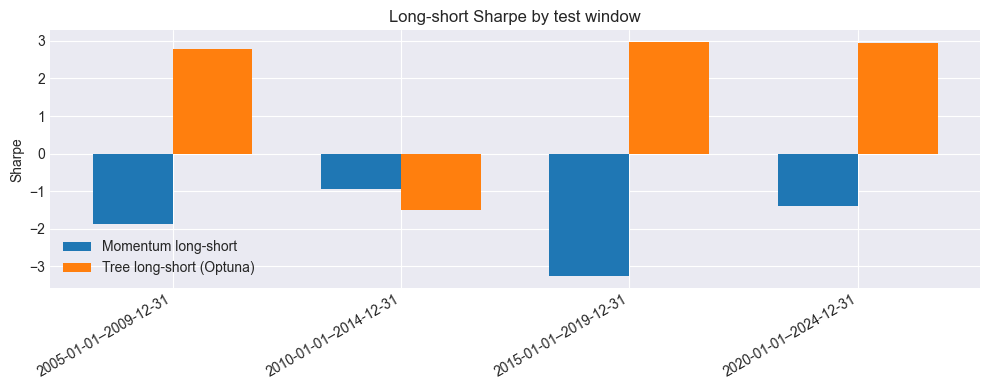

In [12]:
# Nice labels for windows
window_labels = (
    results_df["test_start"].astype(str)
    + "–"
    + results_df["test_end"].astype(str)
)
x = np.arange(len(results_df))
width = 0.35

# --- Long-only Sharpe: momentum vs tree ---
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, results_df["momL_sharpe"], width, label="Momentum long-only")
plt.bar(x + width/2, results_df["treeL_sharpe"], width, label="Tree long-only (Optuna)")
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Sharpe")
plt.title("Long-only Sharpe by test window")
plt.legend()
plt.tight_layout()
plt.show()

# --- Long-short Sharpe: momentum vs tree ---
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, results_df["momLS_sharpe"], width, label="Momentum long-short")
plt.bar(x + width/2, results_df["treeLS_sharpe"], width, label="Tree long-short (Optuna)")
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Sharpe")
plt.title("Long-short Sharpe by test window")
plt.legend()
plt.tight_layout()
plt.show()


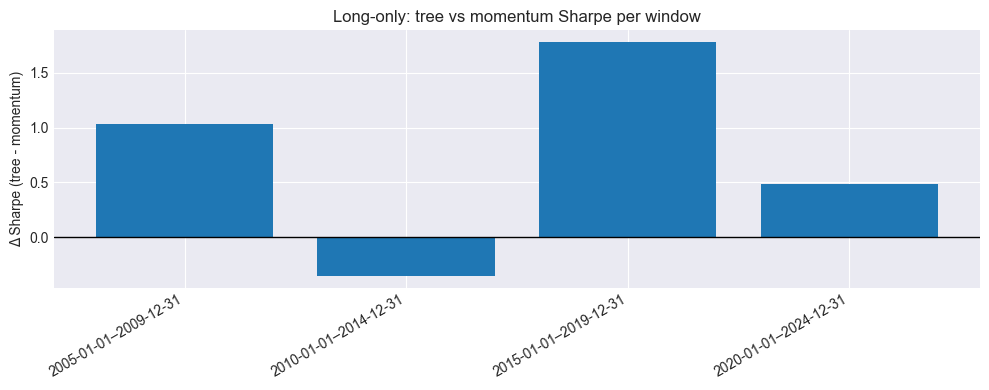

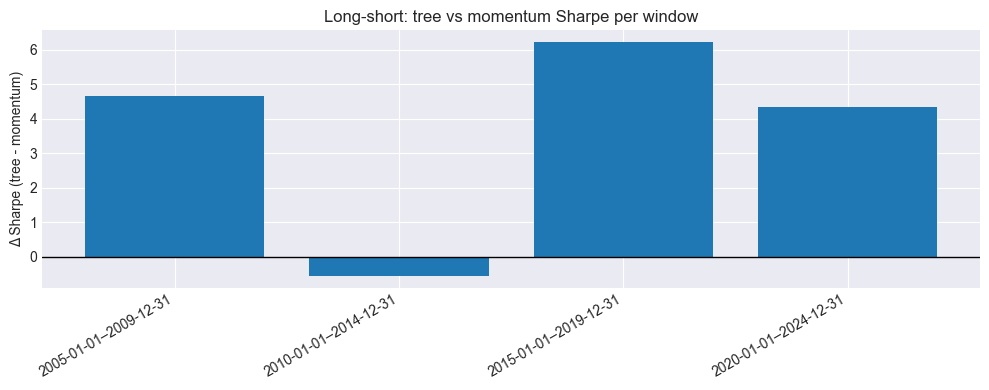

In [13]:
# Add differences if not already there
results_df["treeL_minus_momL"]   = results_df["treeL_sharpe"]  - results_df["momL_sharpe"]
results_df["treeLS_minus_momLS"] = results_df["treeLS_sharpe"] - results_df["momLS_sharpe"]

plt.figure(figsize=(10, 4))
plt.bar(x, results_df["treeL_minus_momL"])
plt.axhline(0, color="black", linewidth=1)
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Δ Sharpe (tree - momentum)")
plt.title("Long-only: tree vs momentum Sharpe per window")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(x, results_df["treeLS_minus_momLS"])
plt.axhline(0, color="black", linewidth=1)
plt.xticks(x, window_labels, rotation=30, ha="right")
plt.ylabel("Δ Sharpe (tree - momentum)")
plt.title("Long-short: tree vs momentum Sharpe per window")
plt.tight_layout()
plt.show()


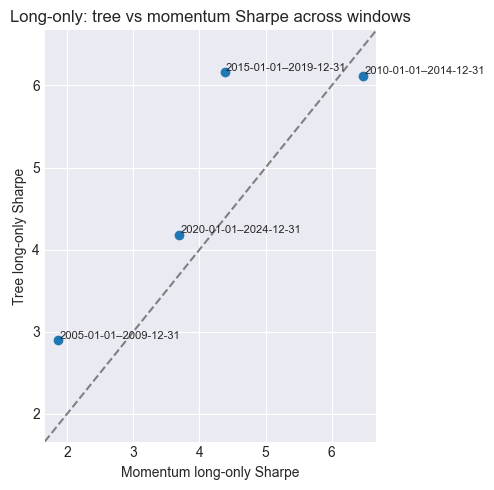

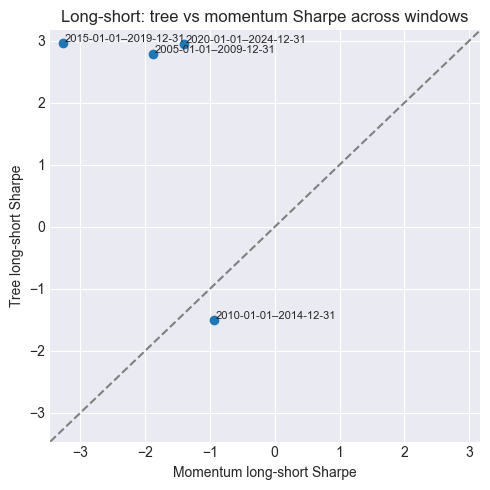

In [14]:
# Long-only scatter
plt.figure(figsize=(5, 5))
plt.scatter(results_df["momL_sharpe"], results_df["treeL_sharpe"])
lims = [
    min(results_df["momL_sharpe"].min(), results_df["treeL_sharpe"].min()) - 0.2,
    max(results_df["momL_sharpe"].max(), results_df["treeL_sharpe"].max()) + 0.2,
]
plt.plot(lims, lims, "--", color="gray")  # y = x line
for i, label in enumerate(window_labels):
    plt.text(
        results_df["momL_sharpe"].iloc[i] + 0.02,
        results_df["treeL_sharpe"].iloc[i] + 0.02,
        label,
        fontsize=8,
    )
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Momentum long-only Sharpe")
plt.ylabel("Tree long-only Sharpe")
plt.title("Long-only: tree vs momentum Sharpe across windows")
plt.tight_layout()
plt.show()

# Long-short scatter
plt.figure(figsize=(5, 5))
plt.scatter(results_df["momLS_sharpe"], results_df["treeLS_sharpe"])
lims = [
    min(results_df["momLS_sharpe"].min(), results_df["treeLS_sharpe"].min()) - 0.2,
    max(results_df["momLS_sharpe"].max(), results_df["treeLS_sharpe"].max()) + 0.2,
]
plt.plot(lims, lims, "--", color="gray")
for i, label in enumerate(window_labels):
    plt.text(
        results_df["momLS_sharpe"].iloc[i] + 0.02,
        results_df["treeLS_sharpe"].iloc[i] + 0.02,
        label,
        fontsize=8,
    )
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Momentum long-short Sharpe")
plt.ylabel("Tree long-short Sharpe")
plt.title("Long-short: tree vs momentum Sharpe across windows")
plt.tight_layout()
plt.show()
